In [1]:
from spd.MajoranaRepresentation import MajoranaRepresentation
from spd.PauliRepresentation import PauliRepresentation
from spd.SparsePauliDynamics import Simulation
from spd.utils import *

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from qiskit.quantum_info import SparsePauliOp, PauliList, Pauli
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper

In [2]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
nelec = 2
norb = 2
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
obs = FermionicOp({"+_0 -_0": 1.0}, num_spin_orbitals=4)

dt = 0.1
nsteps = 100
threshold = 0

## Majorana simulation

In [3]:
observable = MajoranaRepresentation.from_fermionic_op(obs)
h = MajoranaRepresentation.fermionic_to_sparse_pauli_op(hamiltonian)
hf_state = np.array(HartreeFock(norb, (nelec//2, nelec//2), JordanWignerMapper())._bitstr)
sim = Simulation(observable, dt*h, threshold=threshold)
r_majorana = sim.run_dynamics(nsteps, process=partial(MajoranaRepresentation.exp_val_comp_basis_state, state=hf_state), process_every=1)

## Pauli simulation

In [4]:
mapper = JordanWignerMapper()
observable = mapper.map(obs)
h = mapper.map(hamiltonian)
hf_state = np.array(HartreeFock(norb, (nelec//2, nelec//2), mapper)._bitstr)
sim = Simulation.from_pauli_list(observable, dt*h, threshold=threshold)
r_pauli = sim.run_dynamics(nsteps, process=partial(PauliRepresentation.exp_val_comp_basis_state, state=hf_state), process_every=1)

## Compare

In [5]:
np.linalg.norm(np.array(r_majorana) - np.array(r_pauli))

1.1157603309187458e-15

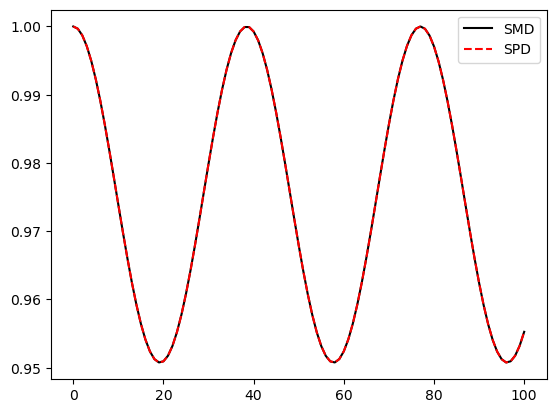

In [6]:
plt.plot(np.arange(len(r_majorana)), np.real(r_majorana), '-k', label='SMD')
plt.plot(np.arange(len(r_pauli)), np.real(r_pauli), '--r', label='SPD')
plt.legend(loc=1)
plt.show()